In [1]:
import pandas as pd 
import numpy as np 

from load_rankings import load_imp
from disagreement_stats import feature_agreement, rank_agreement, rank_correlation, weak_rank_agreement
import itertools
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
def to_rankings(df):
    """
    Convert feature attributions to a list of top features.
    """
    columns = df.columns
    contrib_features = [c for c in columns if 'contrib' in c and 'Bias' not in c]
    vals = df[contrib_features].values[0,:]
    inds = np.argsort(np.absolute(vals))[::-1]
    vals[inds]
    features = [c.replace('_contrib', '') for c in contrib_features]
    rankings = list(np.array(features)[inds])
    
    return rankings 

In [3]:
keys = ['Best_Hits', 'Worst_Misses', 'Worst_False_Alarms', 'Best_Corr._Negatives']
methods = ['lime', 'shap_ds', 'ti']

data = {}

for key in keys:
    _data=[]
    for method in methods:
        df = pd.read_pickle(f'{method}_results_{key}.pkl')
        ranking = to_rankings(df)
        _data.append(ranking)
    data[key] = _data

In [4]:
def compute_matrices(data, methods):
    n_rankings = len(methods)
    
    feature_agree = np.zeros((n_rankings, n_rankings))
    rank_agree = np.zeros((n_rankings, n_rankings))
    
    for i, j in itertools.product(range(n_rankings), range(n_rankings)):
        m1,m2 = methods[i], methods[j]
        
        r1 = data[i][:10]
        r2 = data[j][:10]
    
        feature_agree[i,j] = feature_agreement(r1, r2)
        rank_agree[i,j] = weak_rank_agreement(r1, r2)
    
    return feature_agree, rank_agree

In [5]:
results = {}
for key in data.keys():
    feature_agree, rank_agree = compute_matrices(data[key], methods)
    
    results[key] = {
        'feature_agree' : feature_agree,
        'rank_agree' : rank_agree,
    }

In [6]:
def set_row_labels(labels, axes, pos=0, pad=1.15, rotation=90, **kwargs):
        """
        Give a label to each row in a series of subplots
        """
        colors = kwargs.get("colors", ["xkcd:darkish blue"] * len(labels))
        fontsize = kwargs.get("fontsize", 10)

        if np.ndim(axes) == 2:
            iterator = axes[:, pos]
        else:
            iterator = [axes[pos]]

        for ax, row, color in zip(iterator, labels, colors):
            ax.yaxis.set_label_position("right")
            ax.annotate(
                row,
                xy=(1, 1),
                xytext=(pad, 0.5),
                xycoords=ax.transAxes,
                rotation=rotation,
                size=fontsize,
                ha="center",
                va="center",
                color=color,
                alpha=0.65,
            )


def add_alphabet_label(n_panels, axes, pos=(0.9, 0.09), alphabet_fontsize=10, **kwargs):
        """
        A alphabet character to each subpanel.
        """
        alphabet_list = [chr(x) for x in range(ord("a"), ord("z") + 1)] + [
            f"{chr(x)}{chr(x)}" for x in range(ord("a"), ord("z") + 1)
        ]

        ax_iterator = axes.flat

        for i, ax in enumerate(ax_iterator):
            ax.text(
                pos[0],
                pos[1],
                f"({alphabet_list[i]})",
                fontsize=alphabet_fontsize,
                alpha=0.8,
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
def plot_heatmap(ax, data, labels):
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True  
    ax = sns.heatmap(data, vmin=0, vmax=1, cmap='Reds', 
                annot=True, annot_kws={'fontsize': 10}, 
                xticklabels=labels, yticklabels=labels,
                ax=ax, mask=mask, cbar=False, square=True,
               )
    
    ax.axvline(x=4, ymax=0.425, ls='dashed', color='white', alpha=1.0, lw=1.5)
    ax.axhline(y=4, xmax=0.575, ls='dashed', color='white', alpha=1.0, lw=1.5)
    
    ax.set_yticklabels(labels, rotation = 'horizontal')
    return ax


def heatmap_multi(results, hazards):
    nrows = 2
    fig, axes = plt.subplots(dpi=300, nrows=2, ncols=4, figsize=(14,6))
    
    modes = ['feature_agree']*4 + ['rank_agree']*4

    labels=['LIME', 'TI', 'SHAP']
    for ax, key, mode in zip(axes.flat, keys*2, modes):

        ax = plot_heatmap(ax, results[key][mode], labels = labels)
        mappable = ax.collections[0]
        
    add_alphabet_label(n_panels=8, axes=axes, pos=(0.95, 0.95), alphabet_fontsize=10,)
    
    for ax, hazard in zip(axes[0,:], hazards):
        ax.set_title(hazard.replace('_', ' ').title(), color='xkcd:medium blue', fontsize=12)

    set_row_labels(['Top Feature\nAgreement (N=10)', 'Feature Rank\nAgreement (N=10)'], 
                   axes, pos=0, pad=-0.32, rotation=90,)   
    
    plt.subplots_adjust(wspace=0.2)
    cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.95, label='Agreement' ) 
    cbar.ax.tick_params(labelsize=12)

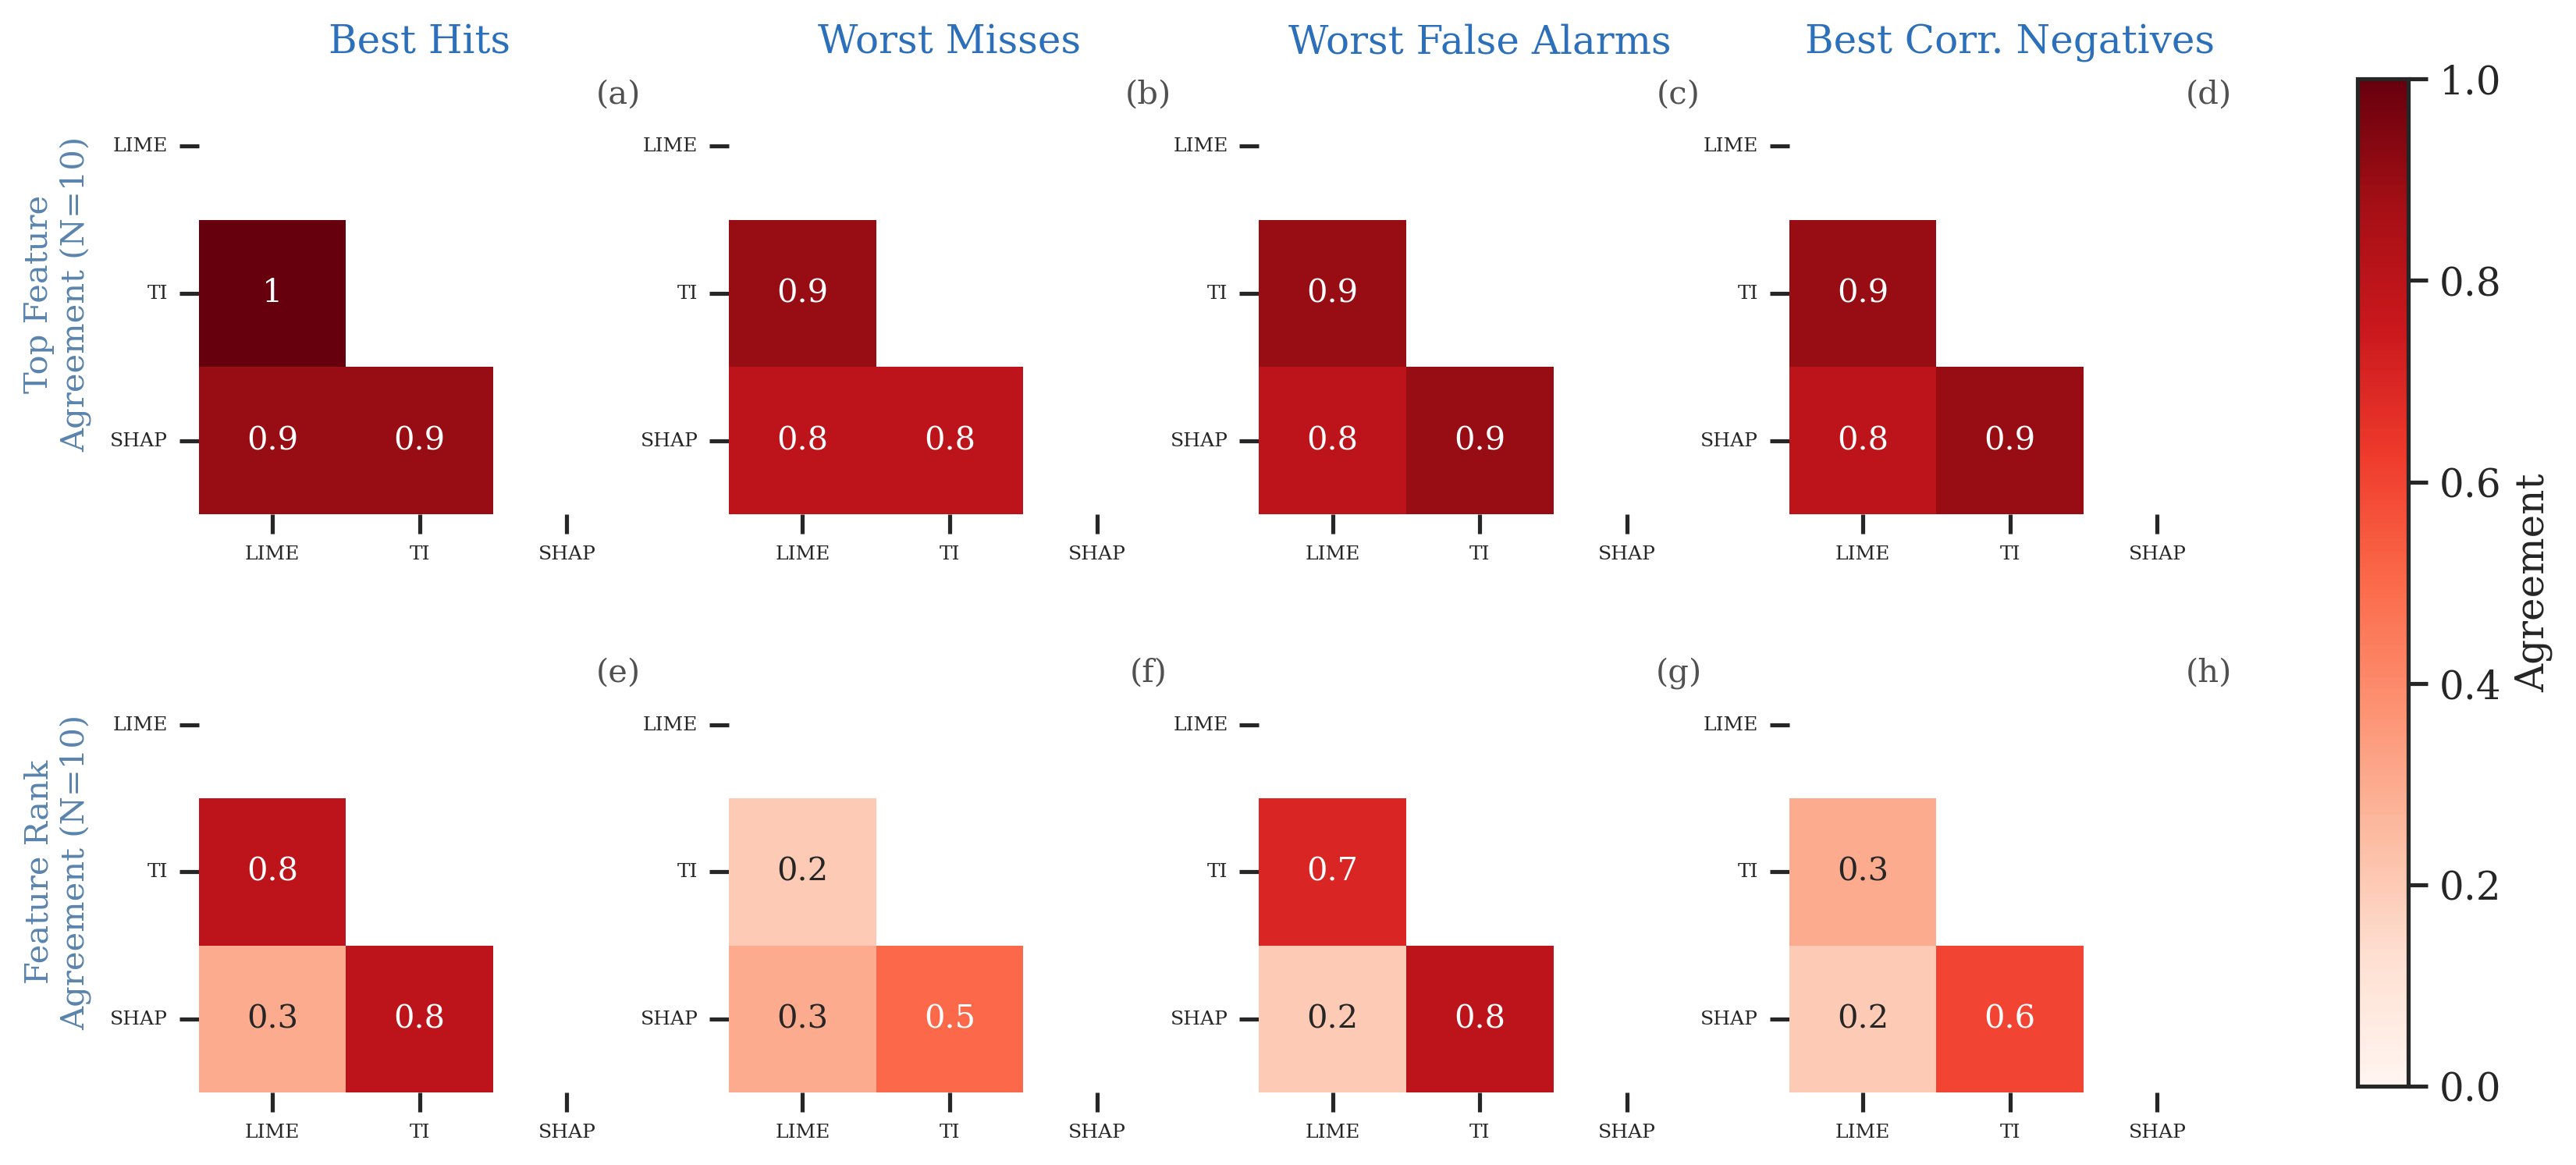

In [7]:
heatmap_multi(results, keys)